# Contributions of moisture transport, evaporation and precipitation

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import atmotrans as atm

## ERA5 - entire monsoon season

In [466]:
### seasonal means  ###
time = np.arange(1979,2020)

f= '../moisture_transport/moisture_transport/cache/srfc-monthly/prcp_annual_means.nc'
p = xr.open_dataset(f)
data = p.copy()
prcp = p.tp[:,:-1,:-1]*1000
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/evapo_annual_means.nc'
e = xr.open_dataset(f)
evapo = e.e[:,:-1,:-1]*-1000
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/moistdiv_annual_means.nc'
m= xr.open_dataset(f)
mfc = - m['vimd'][:,:-1,:-1] 
mfc_clim = mfc.mean(dim='time')


f= '/media/juli/Data/projects/data/satellite_data/gpm_v06/monthly_means/gpm_summer_timeseries.nc4'
gpm = xr.open_dataset(f)
gpm_prcp = np.flip(gpm.precipitationCal.T *30.25, axis = 0)


gpm.close()
m.close()
p.close()
e.close()

In [467]:
# calculate weightes mean area
def weighted_mean_timeseries(arr, data, latstr, lonstr, gpm = False ):
    if gpm is True:
        dataset=xr.DataArray(arr,  dims= {'time':data[latstr].values, latstr: data[latstr].values, lonstr: data[lonstr].values})
        weights = np.cos(np.deg2rad(data[latstr]))
    else:
        dataset=xr.DataArray(arr,  dims= {'time':data[latstr][:-1].values, latstr: data[latstr][:-1].values, lonstr: data[lonstr][:-1].values})
        weights = np.cos(np.deg2rad(data[latstr][:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean((latstr, lonstr), skipna= True)
    return weighted_mean.values


In [468]:
# Extract timeseries for specific regions 

### TP ###
dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
elevation = xr.open_dataset(dem)['elevation']
elevations_tp= elevation[800:1200, 1840:2480]
lat = np.linspace(800,1199,200)
lon= np.linspace(1840,2479,320)
gpmlat = np.linspace(800,1199,500)
gpmlon= np.linspace(1840,2479,800)
elevs= elevations_tp.interp(nlat= lat, nlon= lon )
elevs_gpm= elevations_tp.interp(nlat= gpmlat, nlon= gpmlon )
elevs= np.flip(elevs, axis = 0 )
mfc_tp= mfc.copy()
prcp_tp = prcp.copy()
gpm_prcp_tp = gpm_prcp.copy()
evapo_tp = evapo.copy()
mfc_tp.values[:,elevs < 3000 ] = np.nan
prcp_tp.values[:,elevs < 3000] = np.nan
gpm_prcp_tp.values[elevs_gpm < 3000, : ] = np.nan
evapo_tp.values[:,elevs < 3000 ] = np.nan

### Land ### 
lm= xr.open_dataset('../moisture_transport/moisture_transport/lsm_era5_tp.nc')['lsm'][0]
lsm= np.flip(lm, axis = 0)
lsm_gpm= lsm.interp(lat= gpm_prcp.lat.values, lon= gpm_prcp.lon.values )
mfc_land= mfc.copy()
prcp_land= prcp.copy()
gpm_prcp_land= gpm_prcp.copy()
evapo_land= evapo.copy()
mfc_land.values[:, lsm == 0] = np.nan
prcp_land.values[:, lsm== 0 ] = np.nan
gpm_prcp_land.values[lsm_gpm == 0, : ] = np.nan
evapo_land.values[:, lsm == 0] = np.nan

### convergence zones ###
mfc_con= mfc.copy()
prcp_con= prcp.copy()
evapo_con= evapo.copy()
gpm_prcp_con = gpm_prcp.copy()
mfc_con.values[:, mfc_clim < 0] = np.nan
prcp_con.values[:,  mfc_clim < 0 ] = np.nan
mfc_clim_gpm = mfc_clim.interp(latitude= gpm_prcp.lat.values, longitude= gpm_prcp.lon.values )
gpm_prcp_con.values[mfc_clim_gpm < 0, : ] = np.nan
evapo_con.values[:, mfc_clim < 0] = np.nan

### divergence zones ###
mfc_div= mfc.copy()
prcp_div= prcp.copy()
evapo_div= evapo.copy()
gpm_prcp_div = gpm_prcp.copy()
mfc_div.values[:, mfc_clim > 0] = np.nan
prcp_div.values[:,  mfc_clim > 0 ] = np.nan
gpm_prcp_div.values[mfc_clim_gpm > 0 ,:] = np.nan
evapo_div.values[:, mfc_clim > 0] = np.nan

In [469]:
# area-weighted means timeseries
gpm_prcp = gpm_prcp.T.values.swapaxes(1,2)
gpm_prcp_tp = gpm_prcp_tp.T.values.swapaxes(1,2)
gpm_prcp_land = gpm_prcp_land.T.values.swapaxes(1,2)
gpm_prcp_con = gpm_prcp_con.T.values.swapaxes(1,2)
gpm_prcp_div = gpm_prcp_div.T.values.swapaxes(1,2)


p_tp = weighted_mean_timeseries(prcp_tp-np.nanmean(prcp_tp, axis = 0), data,'latitude', 'longitude' )
precip_tp = weighted_mean_timeseries(gpm_prcp_tp - np.nanmean(gpm_prcp_tp, axis = 0) ,gpm, 'lat', 'lon',gpm=True )
e_tp = weighted_mean_timeseries(evapo_tp- np.nanmean(evapo_tp, axis = 0), data,'latitude', 'longitude' )
mt_tp = weighted_mean_timeseries(mfc_tp- np.nanmean(mfc_tp, axis = 0), data,'latitude', 'longitude' )
p_e_tp = weighted_mean_timeseries( (prcp_tp-np.nanmean(prcp_tp, axis = 0) ) - (evapo_tp- np.nanmean(evapo_tp, axis = 0)), data,'latitude', 'longitude' )

p_land = weighted_mean_timeseries(prcp_land-np.nanmean(prcp_land, axis = 0) , data,'latitude', 'longitude' )
precip_land = weighted_mean_timeseries(gpm_prcp_land-np.nanmean(gpm_prcp_land, axis = 0) , gpm,'lat', 'lon',gpm=True)
e_land = weighted_mean_timeseries(evapo_land- np.nanmean(evapo_land, axis = 0), data,'latitude', 'longitude' )
mt_land = weighted_mean_timeseries(mfc_land- np.nanmean(mfc_land, axis = 0), data,'latitude', 'longitude' )
p_e_land = weighted_mean_timeseries((prcp_land-np.nanmean(prcp_land, axis = 0) ) - (evapo_land- np.nanmean(evapo_land, axis = 0)), data,'latitude', 'longitude' )

p_con = weighted_mean_timeseries(prcp_con-np.nanmean(prcp_con , axis = 0) , data,'latitude', 'longitude' )
precip_con = weighted_mean_timeseries(gpm_prcp_con-np.nanmean(gpm_prcp_con , axis = 0) ,gpm, 'lat', 'lon',gpm=True)
e_con = weighted_mean_timeseries(evapo_con- np.nanmean(evapo_con , axis = 0), data,'latitude', 'longitude' )
mt_con = weighted_mean_timeseries(mfc_con - np.nanmean(mfc_con , axis = 0), data,'latitude', 'longitude' )
p_e_con = weighted_mean_timeseries((prcp_con -np.nanmean(prcp_con , axis = 0) ) - (evapo_con- np.nanmean(evapo_con, axis = 0)), data,'latitude', 'longitude' )

p_div = weighted_mean_timeseries(prcp_div -np.nanmean(prcp_div, axis = 0) , data,'latitude', 'longitude' )
precip_div = weighted_mean_timeseries(gpm_prcp_div -np.nanmean(gpm_prcp_div, axis = 0) , gpm,'lat', 'lon',gpm=True)
e_div = weighted_mean_timeseries(evapo_div - np.nanmean(evapo_div, axis = 0), data,'latitude', 'longitude' )
mt_div = weighted_mean_timeseries(mfc_div - np.nanmean(mfc_div, axis = 0), data,'latitude', 'longitude' )
p_e_div = weighted_mean_timeseries((prcp_div -np.nanmean(prcp_div, axis = 0) ) - (evapo_div- np.nanmean(evapo_div, axis = 0)), data,'latitude', 'longitude' )


## Comparison with GPM precip

In [501]:
### normalize after GPM period ### 

wrf_p_tp,wrf_p_land, wrf_p_con , wrf_p_div = mask_region_time(wrf_p_time - np.nanmean(wrf_p_time[19:-1], axis = 0))
wrf_p_tp,wrf_p_land, wrf_p_con , wrf_p_div = mask_region_time(wrf_p_time - np.nanmean(wrf_p_time[19:-1], axis = 0))
wrf_p_tp,wrf_p_land, wrf_p_con , wrf_p_div = mask_region_time(wrf_p_time - np.nanmean(wrf_p_time[19:-1], axis = 0))
wrf_p_tp,wrf_p_land, wrf_p_con , wrf_p_div = mask_region_time(wrf_p_time - np.nanmean(wrf_p_time[19:-1], axis = 0))



In [502]:
### normalize after GPM period ###

p_tp = weighted_mean_timeseries(prcp_tp-np.nanmean(prcp_tp[20:-2], axis = 0), data,'latitude', 'longitude' )
precip_tp = weighted_mean_timeseries(gpm_prcp_tp - np.nanmean(gpm_prcp_tp, axis = 0) ,gpm, 'lat', 'lon',gpm=True )

p_land = weighted_mean_timeseries(prcp_land-np.nanmean(prcp_land[20:-2], axis = 0) , data,'latitude', 'longitude' )
precip_land = weighted_mean_timeseries(gpm_prcp_land-np.nanmean(gpm_prcp_land, axis = 0) , gpm,'lat', 'lon',gpm=True)


p_con = weighted_mean_timeseries(prcp_con-np.nanmean(prcp_con[20:-2] , axis = 0) , data,'latitude', 'longitude' )
precip_con = weighted_mean_timeseries(gpm_prcp_con-np.nanmean(gpm_prcp_con , axis = 0) ,gpm, 'lat', 'lon',gpm=True)


p_div = weighted_mean_timeseries(prcp_div -np.nanmean(prcp_div[20:-2], axis = 0) , data,'latitude', 'longitude' )
precip_div = weighted_mean_timeseries(gpm_prcp_div -np.nanmean(gpm_prcp_div, axis = 0) , gpm,'lat', 'lon',gpm=True)


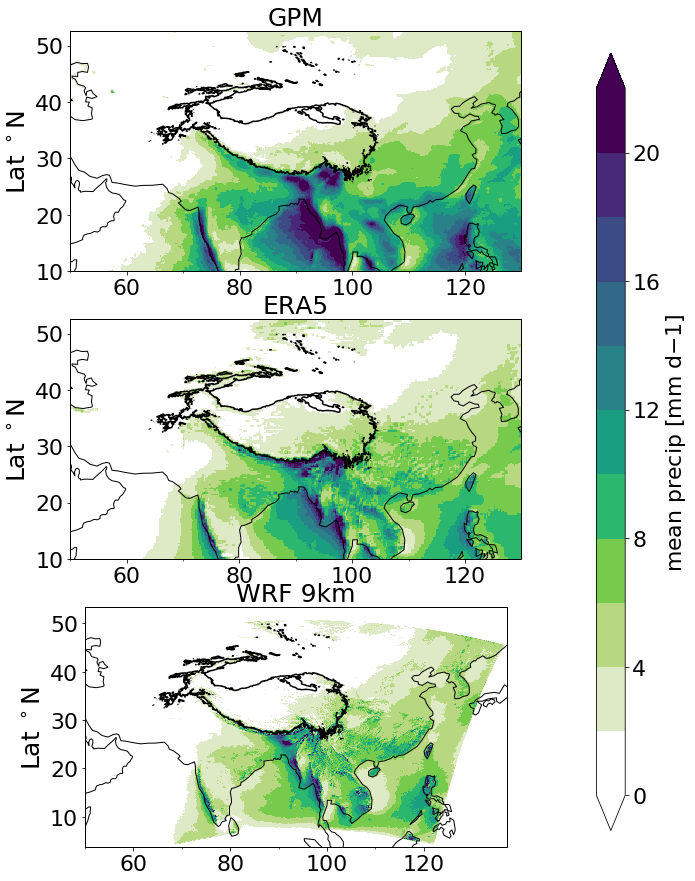

In [540]:
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs

fig =plt.figure(figsize=(10,15))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
fs= 25

# customizing of colorbar 
cmap= viridis_white_r
r = np.arange(0,24,2)

norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
#### ERA5 ##### 
lons = precip.longitude.values
lats = precip.latitude.values

# P
ax1 = plt.subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax1.pcolormesh(lons, lats, np.nanmean(prcp.values, axis =0 ),norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'ERA5', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)

### GPM ### 
lons = gpm.lon.values
lats = gpm.lat.values

ax1 = plt.subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax1.pcolormesh(lons, lats, np.flip(np.nanmean(gpm_prcp, axis=0), axis  =0), norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'GPM', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


### WRF ### 
lons = wrf.lon.values
lats = wrf.lat.values

ax1 = plt.subplot(3, 1, 3, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax1.pcolormesh(lons, lats, wrf_p, norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'WRF 9km', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)



cb_ax1 = fig.add_axes([0.93, 0.14,0.04, 0.72])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mean precip [mm d${-1}$]')
plt.rcParams.update({'font.size': 22})

plt.savefig('plots/comparison_mean_precip_gpm_era5_wrf.png')
plt.show()

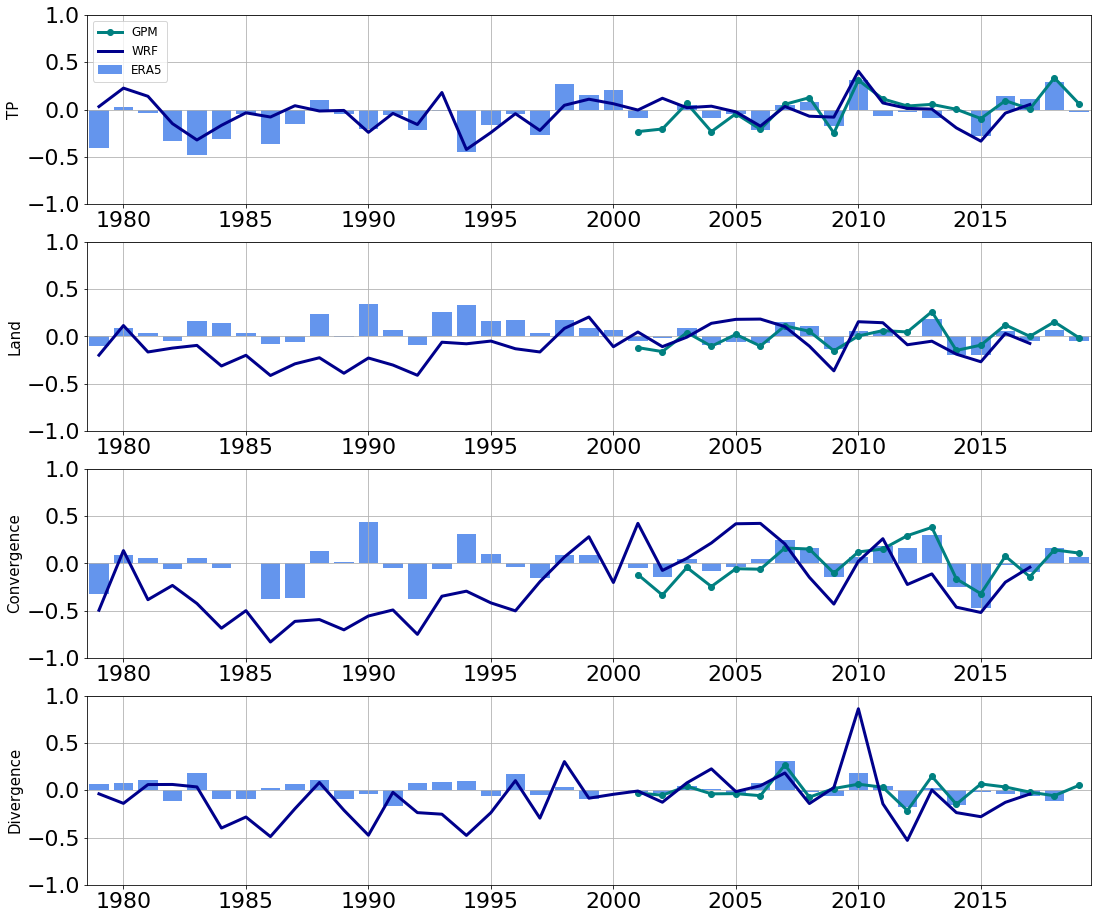

In [508]:
# plot 
s= 15

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(18, 16))
ymin = -1.0
ymax = 1.0


axes[0].plot( np.arange(2001,2020), precip_tp , label = 'GPM', color = 'teal', linewidth = 3, marker = 'o')
axes[0].bar( time, p_tp , label = 'ERA5', color = 'cornflowerblue', linewidth = 2.0)
axes[0].plot( np.arange(1979,2018), wrf_p_tp , label = 'WRF', color = 'darkblue', linewidth = 3.0)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_ylim(ymin,ymax)
axes[0].set_ylabel('TP', fontsize = s)
axes[0].legend(fontsize= 12, loc = 'upper left')
axes[0].grid()

axes[1].plot( np.arange(2001,2020), precip_land , label = 'GPM', color = 'teal', linewidth = 3, marker = 'o')
axes[1].bar( time, p_land , label = 'ERA5', color = 'cornflowerblue', linewidth = 2.0)
axes[1].plot( np.arange(1979,2018), wrf_p_land , label = 'WRF', color = 'darkblue', linewidth = 3.0)
axes[1].set_ylabel('Land', fontsize = s)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_ylim(ymin,ymax)
axes[1].grid()


axes[2].plot( np.arange(2001,2020), precip_con , label = 'GPM', color = 'teal', linewidth = 3, marker = 'o')
axes[2].bar( time, p_con , label = 'ERA5', color = 'cornflowerblue', linewidth = 2.0)
axes[2].plot( np.arange(1979,2018), wrf_p_con , label = 'WRF', color = 'darkblue', linewidth = 3.0)
axes[2].set_ylabel('Convergence', fontsize = s)
axes[2].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[2].set_ylim(ymin,ymax)
axes[2].grid()

axes[3].plot( np.arange(2001,2020), precip_div, label = 'GPM', color = 'teal', linewidth = 3, marker = 'o')
axes[3].bar( time, p_div , label = 'ERA5', color = 'cornflowerblue', linewidth = 2.0)
axes[3].plot(np.arange(1979,2018), wrf_p_div , label = 'WRF', color = 'darkblue', linewidth = 3.0)
axes[3].set_ylabel('Divergence', fontsize = s)
axes[3].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[3].set_ylim(ymin,ymax)
axes[3].grid()

plt.savefig('plots/precip_comparison_wrf_gpm.png')
plt.show()


## ERA5 interannual variability

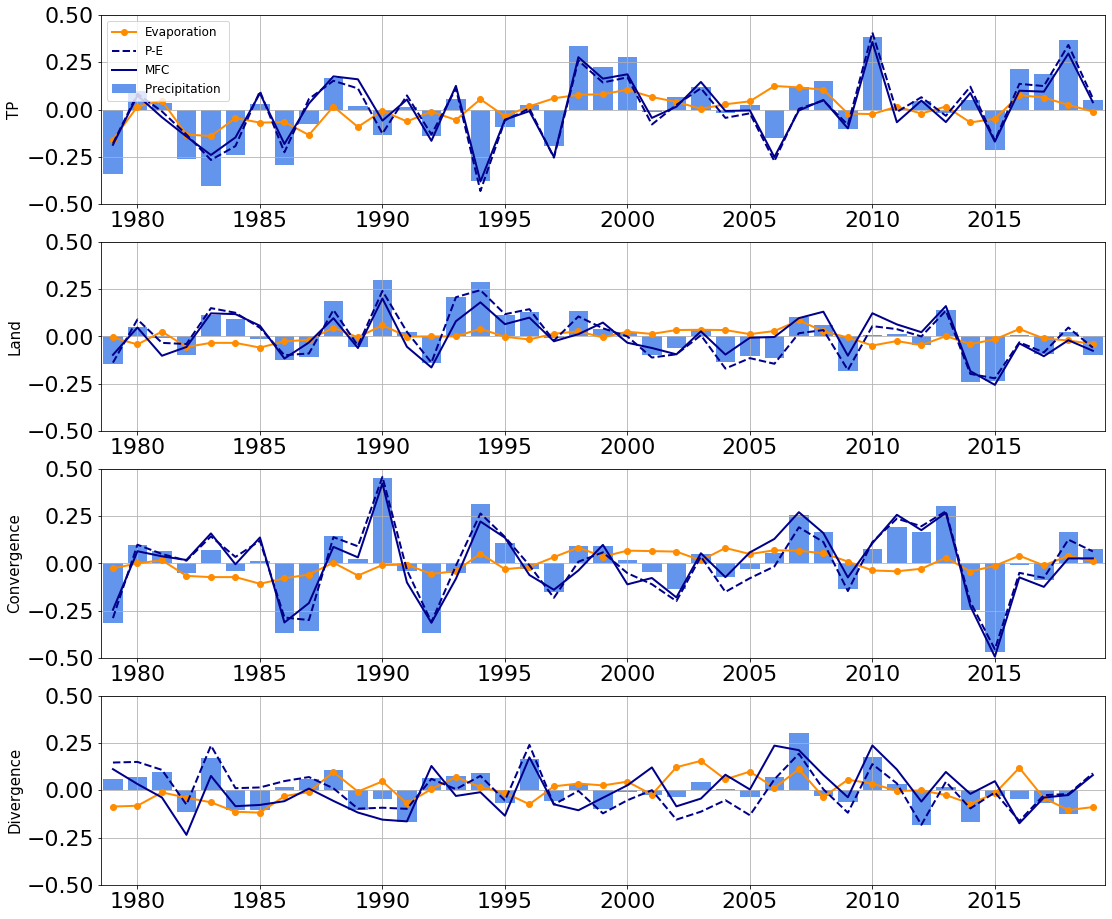

In [428]:
# plot 

s= 15

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(18, 16))


axes[0].bar( time, p_tp , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[0].plot(time, e_tp  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[0].plot(time, p_e_tp  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[0].plot(time, mt_tp , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_ylabel('TP', fontsize = s)
axes[0].legend(fontsize= 12, loc = 'upper left')
axes[0].grid()


axes[1].bar( time, p_land , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[1].plot(time, e_land  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[1].plot(time, p_e_land  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[1].plot(time, mt_land  , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[1].set_ylabel('Land', fontsize = s)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_ylim(-0.5, 0.5)
axes[1].grid()

axes[2].bar( time, p_con , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[2].plot(time, e_con  , label = 'Evaporation', color = 'darkorange', marker = 'o', linewidth = 2.0)
axes[2].plot(time, p_e_con  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[2].plot(time, mt_con  , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[2].set_ylabel('Convergence', fontsize = s)
axes[2].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[2].set_ylim(-0.5, 0.5)
axes[2].grid()


axes[3].bar( time, p_div , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[3].plot(time, e_div  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[3].plot(time, p_e_div  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[3].plot(time, mt_div , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[3].set_ylabel('Divergence', fontsize = s)
axes[3].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[3].set_ylim(-0.5, 0.5)
axes[3].grid()

plt.savefig('plots/components.png')
plt.show()


## How much is the contribution from local evaporation in each year vs. contribution to mean 

In [93]:
np.abs(e_tp)/ np.abs(p_tp)

array([0.47035523, 0.15963854, 1.26301669, 0.50052764, 0.34449259,
       0.18869743, 2.44804351, 0.22674944, 1.71736142, 0.09509801,
       4.60339146, 0.04293351, 5.26916355, 0.0727214 , 0.97403388,
       0.14563042, 0.38233614, 0.74112316, 0.30572896, 0.23149815,
       0.36129794, 0.38155416, 5.25389311, 0.62072313, 0.0368877 ,
       1.74942442, 1.84049132, 0.84057796, 0.96565934, 0.687207  ,
       0.20721331, 0.06228626, 4.85542123, 0.46632749, 0.95203752,
       1.28717043, 0.22791333, 0.35836628, 0.33922269, 0.06639986,
       0.20628231])

In [90]:
mean_contr=np.nanmean(evapo_tp, axis = 0)/ np.nanmean(prcp_tp, axis = 0)
np.nanmean(mean_contr)

0.7427517758414742

What are the robust convergence/ divergence zones? 

~  90% at least mean (climatological value)

In [234]:
yearcount = np.zeros(mfc_clim.shape)

for y in np.arange(41):
    year= mfc_con[y]
    yearcount[year <= mfc_clim ] += 1 
    
yearcount[yearcount == 0] = np.nan

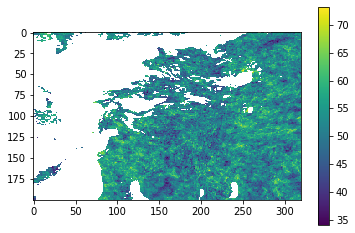

In [235]:
plt.imshow(yearcount/41 * 100)
plt.colorbar()

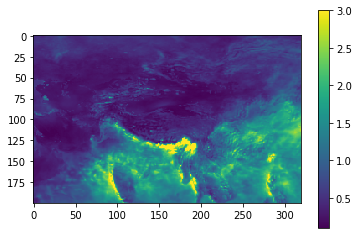

In [223]:
# stanard deviation moisture flux divergence
plt.imshow(np.nanstd(mfc,axis = 0),vmin = 0.1, vmax = 3, cmap = 'viridis')
plt.colorbar()

## WRF vs. ERA5 moisture budget components 

In [477]:
f= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_climatology.nc'
wrf= xr.open_dataset(f)
wrf_p = wrf.precip_g[0].values
wrf_e = wrf.WaterFlx[0].values

## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values

f= '../moisture_transport/moisture_transport/cache/era5_clim_precip_1979-2017.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
f= '../moisture_transport/moisture_transport/cache/era5_clim_evapo_1979-2017.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* - 1000
f= '../moisture_transport/moisture_transport/cache/era5_clim_moistdiv_1979-2017.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd = - moisture['vimd'].values[0] 

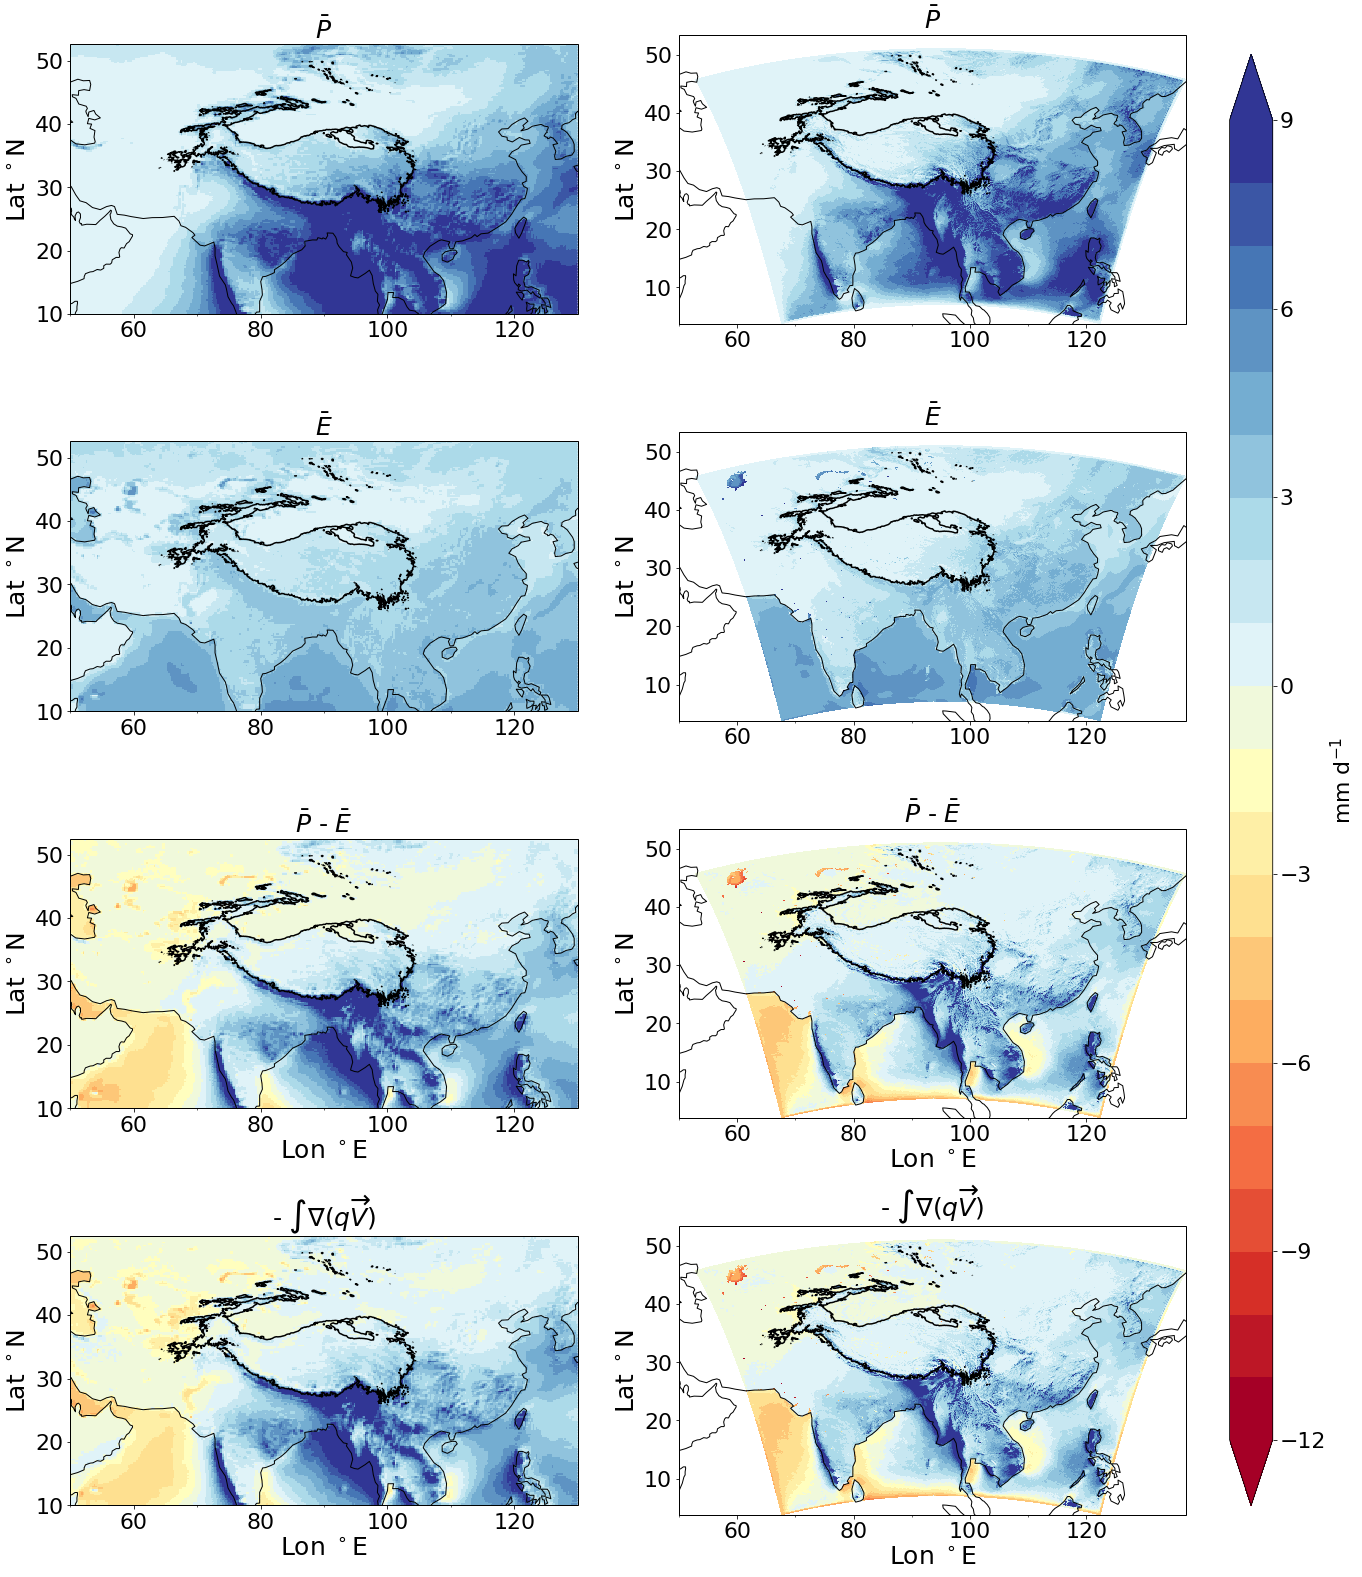

In [483]:
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs

fig =plt.figure(figsize=(20,28))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
fs= 25

# customizing of colorbar 
cmap=plt.cm.RdYlBu
#cmap=plt.cm.Spectral
r = np.arange(-12,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = wrf.lon.values
lats = wrf.lat.values

# P
ax1 = plt.subplot(4, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax1.pcolormesh(lons, lats, wrf_p,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(4, 2, 4, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax2.pcolormesh(lons, lats, wrf_e, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

# P - E
ax3 = plt.subplot(4, 2, 6, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, wrf_p - wrf_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# MFC
ax3 = plt.subplot(4, 2, 8, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, wrf_p - wrf_e ,norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'- $\int \nabla (q\overrightarrowV)$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)




#### ERA5 ##### 
lons = precip.longitude.values
lats = precip.latitude.values


# P
ax1 = plt.subplot(4, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax1.pcolormesh(lons, lats, P ,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(4, 2, 3, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# MFC
ax3 = plt.subplot(4, 2, 7, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, vimd, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'- $\int \nabla (q \overrightarrowV)$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)



# P - E
ax3 = plt.subplot(4, 2, 5, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, P-E, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)




cb_ax1 = fig.add_axes([0.93, 0.14,0.03, 0.72])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm d$^{-1}$')
plt.rcParams.update({'font.size': 22})


plt.savefig('plots/wrf_moisture_budget_comparison_wrf_era5.png',bbox_inches="tight")
plt.show()

## Variance of components

In [184]:
f= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_std.nc'
wrf= xr.open_dataset(f)
wrf_p = wrf.precip_g[0].values
wrf_e = wrf.WaterFlx[0].values

f= '../moisture_transport/moisture_transport/cache/era5_std_precip_1979-2017.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
f= '../moisture_transport/moisture_transport/cache/era5_std_evapo_1979-2017.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* 1000
f= '../moisture_transport/moisture_transport/cache/era5_std_moistdiv_1979-2017.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd =  moisture['vimd'].values[0] 

In [187]:
from obspy.imaging.cm import viridis_white, viridis_white_r

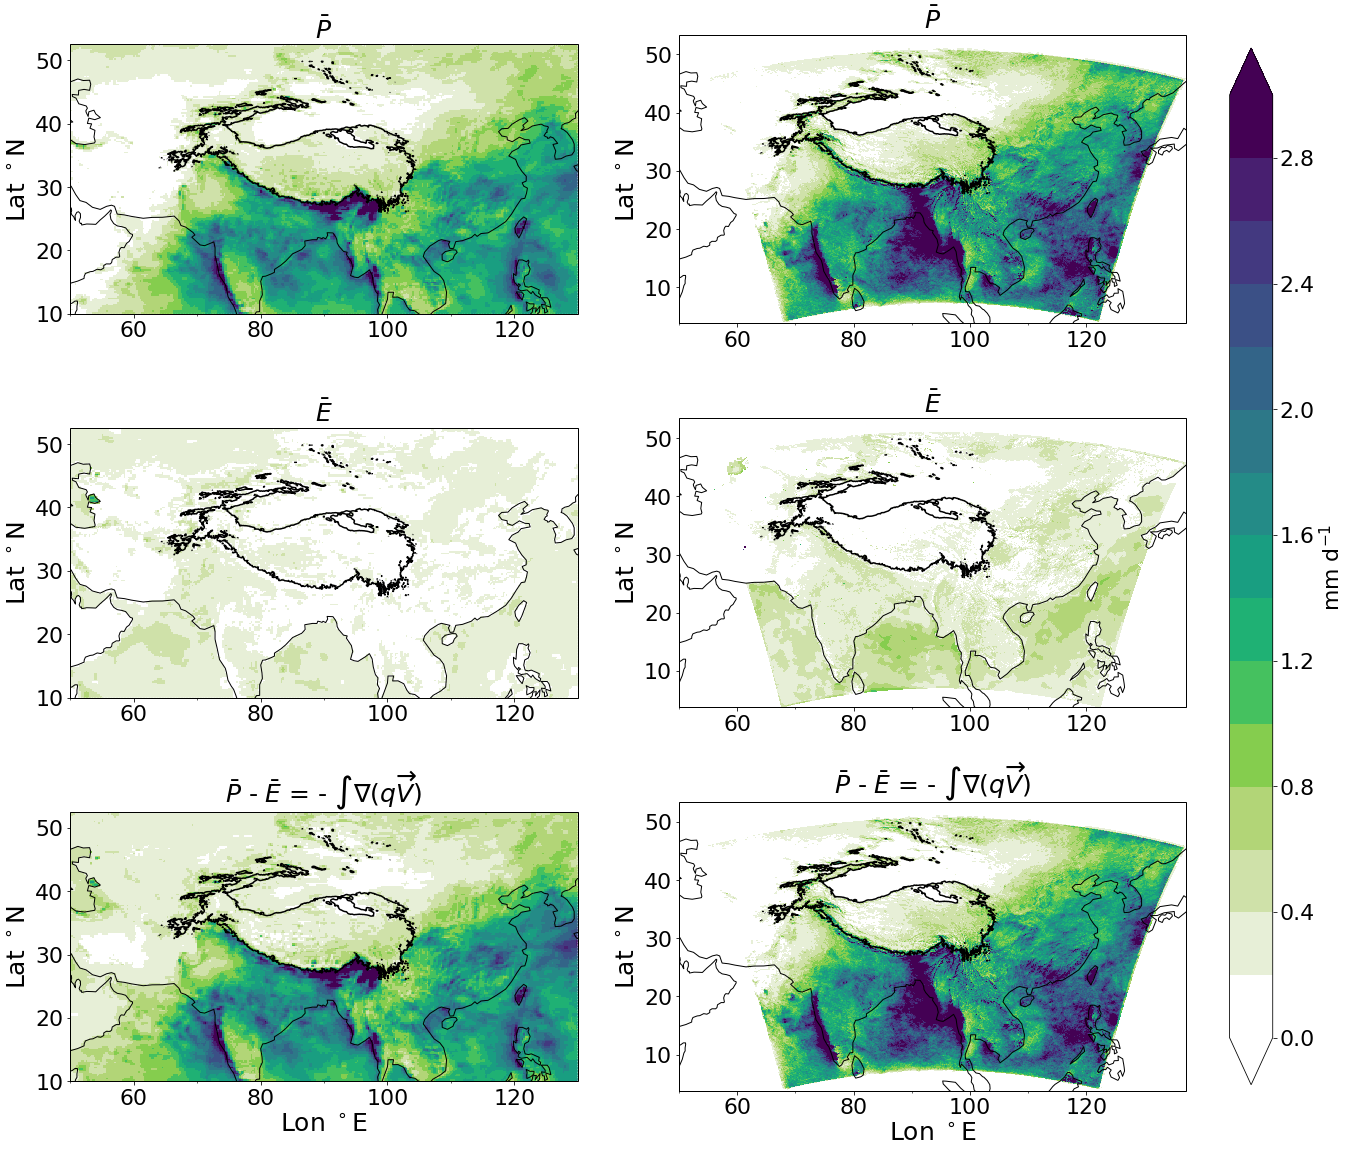

In [192]:
fig =plt.figure(figsize=(20,20))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
fs= 25

# customizing of colorbar 
cmap=plt.cm.RdYlBu
cmap=viridis_white_r
r = np.arange(0,3.2,0.2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = wrf.lon.values
lats = wrf.lat.values

# P
ax1 = plt.subplot(3, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax1.pcolormesh(lons, lats, wrf_p,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(3, 2, 4, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax2.pcolormesh(lons, lats, wrf_e, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

# P - E
ax3 = plt.subplot(3, 2, 6, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, wrf_p , norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$ = - $\int \nabla (q\overrightarrowV)$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)



#### ERA5 ##### 
lons = precip.longitude.values
lats = precip.latitude.values


# P
ax1 = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax1.pcolormesh(lons, lats, P ,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(3, 2, 3, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# P - E
ax3 = plt.subplot(3, 2, 5, projection=ccrs.PlateCarree() ) 
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m=ax3.pcolormesh(lons, lats, vimd, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$ = - $\int \nabla (q \overrightarrowV)$', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)


cb_ax1 = fig.add_axes([0.93, 0.14,0.03, 0.72])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm d$^{-1}$')
plt.rcParams.update({'font.size': 22})


plt.savefig('plots/moisture_budget_variance_wrf_era5.png',bbox_inches="tight")
plt.show()

## WRF timeseries 

In [494]:
wrf_clim = xr.open_dataset('../moisture_transport/moisture_transport/wrftp/data/wrf_precip_evapo_timeseries.nc')
wrf_p_time = wrf_clim.precip_g
wrf_e_time = wrf_clim.WaterFlx
mfc_clim = wrf_p - wrf_e

In [495]:
# calculate weightes mean area
f= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_climatology.nc'
wrf= xr.open_dataset(f)
wrf_p = wrf.precip_g[0].values
wrf_e = wrf.WaterFlx[0].values

## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values

f= '../moisture_transport/moisture_transport/cache/era5_clim_precip_1979-2017.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
lsp = precip.lsp.values[0]*1000
cp = precip.cp.values[0]*1000
f= '../moisture_transport/moisture_transport/cache/era5_clim_evapo_1979-2017.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* - 1000
f= '../moisture_transport/moisture_transport/cache/era5_clim_moistdiv_1979-2017.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd = - moisture['vimd'].values[0]

In [496]:
def mask_region_time(field):
    ### TP ###
    wrf_dem = xr.open_dataset('../moisture_transport/moisture_transport/wrftp/DEM_TP9km.nc').HGT
    elevations_tp= wrf_dem[0].values
    field_tp= field.copy()
    field_tp.values[:, elevations_tp < 3000 ] = np.nan
    
    field_land= field.copy()
    field_land.values[:, elevations_tp == 0 ] = np.nan
 
    ### convergence zones ###
    field_con= field.copy()
    field_con.values[:,mfc_clim < 0] = np.nan

    ### divergence zones ###
    field_div= field.copy()
    field_div.values[:,mfc_clim > 0] = np.nan 
    # area-weighted means timeseries 
    mean_tp = weighted_mean(field_tp)
    mean_con = weighted_mean(field_con)
    mean_div = weighted_mean(field_div) 
    
    ### divergence zones ###
    field_div= field.copy()
    field_div.values[:,mfc_clim > 0] = np.nan 
    
    # area-weighted means timeseries 
    mean_tp = weighted_mean(field_tp)
    mean_con = weighted_mean(field_con)
    mean_div = weighted_mean(field_div)
    mean_land = weighted_mean(field_land)

    return mean_tp, mean_land, mean_con, mean_div

In [497]:
wrf_p_tp,wrf_p_land, wrf_p_con , wrf_p_div = mask_region_time(wrf_p_time - np.nanmean(wrf_p_time, axis = 0))
wrf_e_tp, wrf_e_land,wrf_e_con , wrf_e_div = mask_region_time(wrf_e_time- np.nanmean(wrf_e_time, axis = 0))
wrf_p_e_tp, wrf_p_e_land, wrf_p_e_con , wrf_p_e_div = mask_region_time( (wrf_p_time- wrf_e_time- np.nanmean(wrf_p_time- wrf_e_time, axis = 0)))

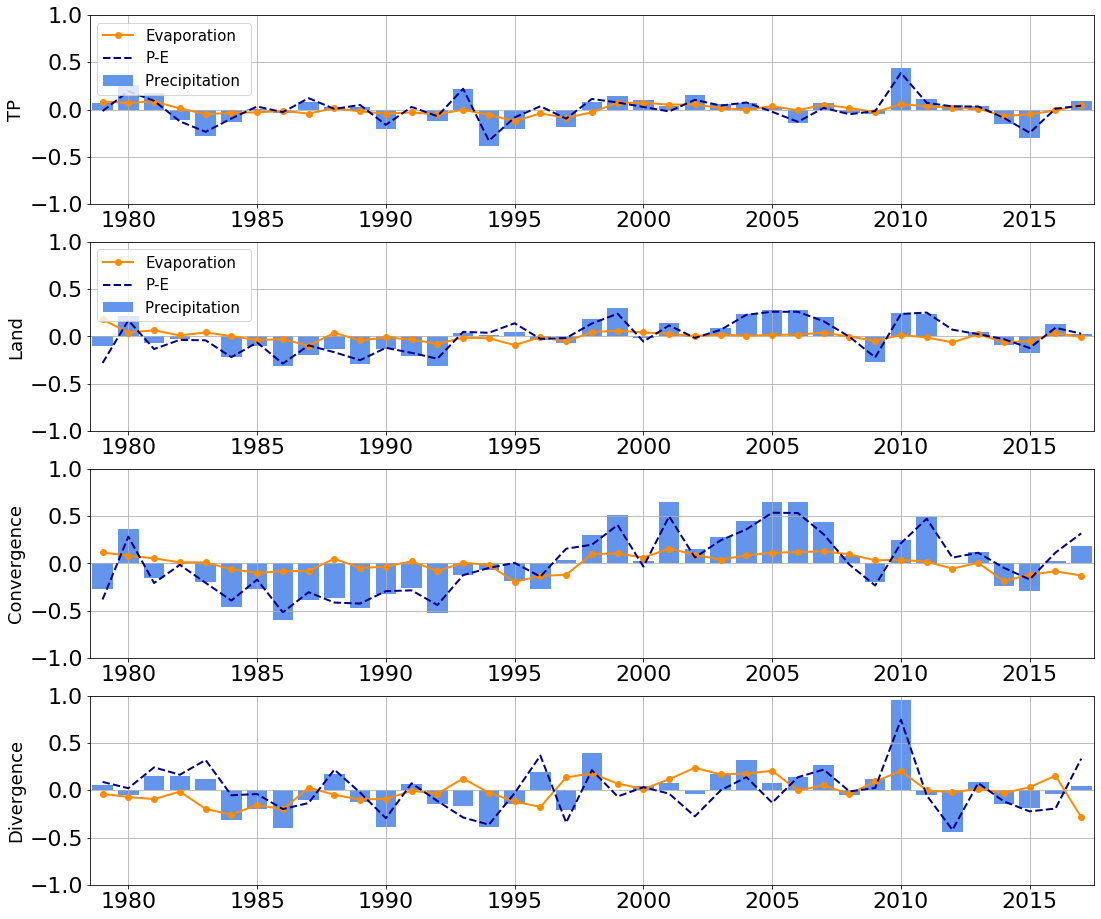

In [148]:
# plot 

s= 18

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(18, 16))

time = np.arange(1979,2018)

ymin = -1.0
ymax = 1.0

axes[0].bar( time, wrf_p_tp , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[0].plot(time, wrf_e_tp  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[0].plot(time, wrf_p_e_tp  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_ylim(ymin,ymax)
axes[0].set_ylabel('TP', fontsize = s)
axes[0].legend(fontsize= 15, loc = 'upper left')
axes[0].grid()


axes[1].bar( time, wrf_p_land , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[1].plot(time, wrf_e_land  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[1].plot(time, wrf_p_e_land  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_ylim(ymin,ymax)
axes[1].set_ylabel('Land', fontsize = s)
axes[1].legend(fontsize= 15, loc = 'upper left')
axes[1].grid()


axes[3].bar( time, wrf_p_div , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[3].plot(time, wrf_e_div  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[3].plot(time, wrf_p_e_div  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[3].set_ylabel('Divergence', fontsize = s)
axes[3].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[3].set_ylim(ymin,ymax)
axes[3].grid()


axes[2].bar( time, wrf_p_con , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[2].plot(time, wrf_e_con  , label = 'Evaporation', color = 'darkorange', marker = 'o', linewidth = 2.0)
axes[2].plot(time, wrf_p_e_con  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[2].set_ylabel('Convergence', fontsize = s)
axes[2].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[2].set_ylim(ymin,ymax)
axes[2].grid()

plt.savefig('plots/components_wrf.png')
plt.show()


## ERA5 - per different months

In [27]:
### anomalies ###
time = np.arange(1979,2020)

f= '../moisture_transport/moisture_transport/cache/prcp/precip_sep_anomalies.nc'
p = xr.open_dataset(f)
prcp = -p.tp[:,:-1,:-1]*1000
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/evapo_sep_anomalies.nc'
e = xr.open_dataset(f)
evapo =- e.e[:,:-1,:-1]*-1000
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/vimd_sep_anomalies.nc'
m = xr.open_dataset(f)
mfc =  m['vimd'][:,:-1,:-1] 

m.close()
p.close()
e.close()

In [28]:
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'time':data.latitude[:-1].values,'latitude':data.latitude[:-1].values, 'longitude':data.longitude[:-1].values})
    weights = np.cos(np.deg2rad(data.latitude[:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean.values

In [29]:
# Extract timeseries for specific regions 


### TP ###
dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
elevation = xr.open_dataset(dem)['elevation']
elevations_tp= elevation[800:1200, 1840:2480]
lat = np.linspace(800,1199,200)
lon= np.linspace(1840,2479,320)
elevs= elevations_tp.interp(nlat= lat, nlon= lon )
elevs= np.flip(elevs, axis = 0 )
mfc_tp= mfc.copy()
prcp_tp = prcp.copy()
evapo_tp = evapo.copy()
mfc_tp.values[:,elevs < 3000 ] = np.nan
prcp_tp.values[:,elevs < 3000 ] = np.nan
evapo_tp.values[:,elevs < 3000 ] = np.nan

### Land ### 
lm= xr.open_dataset('../moisture_transport/moisture_transport/lsm_era5_tp.nc')['lsm'][0].values
lsm= np.flip(lm, axis = 0)
mfc_land= mfc.copy()
prcp_land= prcp.copy()
evapo_land= evapo.copy()
mfc_land.values[:, lsm == 0] = np.nan
prcp_land.values[:, lsm== 0 ] = np.nan
evapo_land.values[:, lsm == 0] = np.nan

### convergence zones ###
mfc_con= mfc.copy()
prcp_con= prcp.copy()
evapo_con= evapo.copy()
mfc_con.values[:, mfc_clim < 0] = np.nan
prcp_con.values[:,  mfc_clim < 0 ] = np.nan
evapo_con.values[:, mfc_clim < 0] = np.nan

### divergence zones ###
mfc_div= mfc.copy()
prcp_div= prcp.copy()
evapo_div= evapo.copy()
mfc_div.values[:, mfc_clim > 0] = np.nan
prcp_div.values[:,  mfc_clim > 0 ] = np.nan
evapo_div.values[:, mfc_clim > 0] = np.nan

In [30]:
# area-weighted means timeseries
p_tp = weighted_mean(prcp_tp)
e_tp = weighted_mean(evapo_tp)
mt_tp = weighted_mean(mfc_tp)
p_e_tp = weighted_mean( prcp_tp - evapo_tp)

p_land = weighted_mean(prcp_land)
e_land = weighted_mean(evapo_land)
mt_land = weighted_mean(mfc_land)
p_e_land = weighted_mean(prcp_land - evapo_land)

p_con = weighted_mean(prcp_con )
e_con = weighted_mean(evapo_con)
mt_con = weighted_mean(mfc_con )
p_e_con = weighted_mean(prcp_con -evapo_con)

p_div = weighted_mean(prcp_div  )
e_div = weighted_mean(evapo_div)
mt_div = weighted_mean(mfc_div )
p_e_div = weighted_mean(prcp_div- evapo_div )


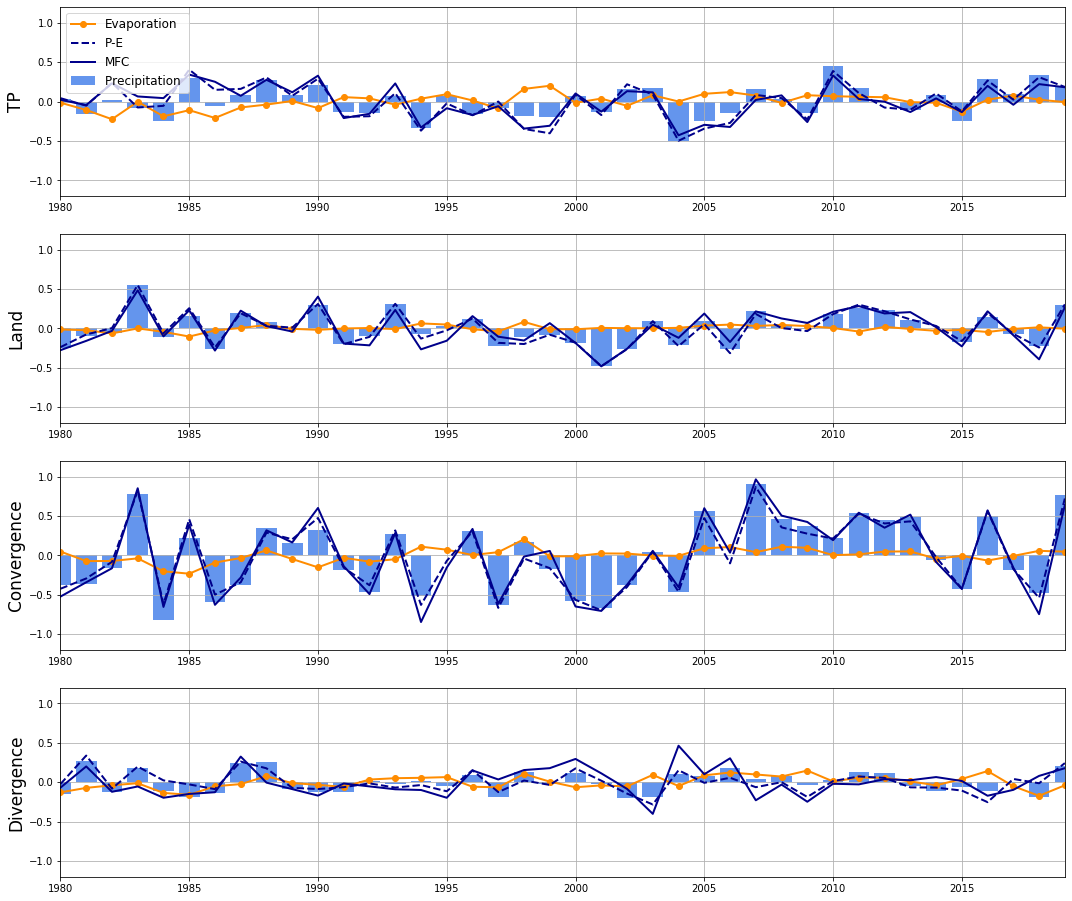

In [31]:
# plot 

s= 17
y_min = -1.2
y_max = 1.2

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(18, 16))

time= np.arange(1980,2020)
axes[0].bar( time, p_tp , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[0].plot(time, e_tp  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[0].plot(time, p_e_tp  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[0].plot(time, mt_tp , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[0].set_xlim(time[0], time[-1])
axes[0].set_ylim(y_min, y_max)
axes[0].set_ylabel('TP', fontsize = s)
axes[0].legend(fontsize= 12, loc = 'upper left')
axes[0].grid()

axes[1].bar( time, p_land , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[1].plot(time, e_land  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[1].plot(time, p_e_land  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[1].plot(time, mt_land  , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[1].set_ylabel('Land', fontsize = s)
axes[1].set_xlim(time[0], time[-1])
axes[1].set_ylim(y_min, y_max)
axes[1].grid()

axes[2].bar( time, p_con , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[2].plot(time, e_con  , label = 'Evaporation', color = 'darkorange', marker = 'o', linewidth = 2.0)
axes[2].plot(time, p_e_con  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[2].plot(time, mt_con  , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[2].set_ylabel('Convergence', fontsize = s)
axes[2].set_xlim(time[0], time[-1])
axes[2].set_ylim(y_min, y_max)
axes[2].grid()


axes[3].bar( time, p_div , label = 'Precipitation ', color = 'cornflowerblue', linewidth = 2.0)
axes[3].plot(time, e_div  , label = 'Evaporation', color = 'darkorange',marker = 'o', linewidth = 2.0)
axes[3].plot(time, p_e_div  , label = 'P-E', color ='darkblue', linestyle = '--',linewidth = 2.0)
axes[3].plot(time, mt_div , label = 'MFC', color = 'darkblue', linewidth= 2.0)
axes[3].set_ylabel('Divergence', fontsize = s)
axes[3].set_xlim(time[0], time[-1])
axes[3].set_ylim(y_min, y_max)
axes[3].grid()


plt.savefig('plots/components_sep.png')
plt.show()